### Recent research by Carnegie Mellon University have proposed that bots may be responsible for up to 50% of tweets for particular topics. Could bots be trying to push certain narritives about particular stocks too and is it possible to find these bots? In this notebook I show my attempt to answer this question by finding bots based on a set of common-sense features and criterias. Then I compare how the Bots tweet compare to average in terms of sentiment correlation with stock price. Suspected bot tweets have significantly higher correlation to stock price than the average sentiment across all writers in the dataset.

**Steps followed:**

**Data Exploration**

**Average Sentiment and Stock Price**

**Feature Engineering**

**"If it tweets like a bot, it is a bot"**

**How does Bot sentiment correlates with Stock Price?**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
pd.set_option('display.max_columns', 30)
sns.set_context("paper", font_scale=2)

#PATH = "/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/"

In [5]:
company = pd.read_csv("Company.csv")
company = company.set_index("ticker_symbol").to_dict()["company_name"]
company

{'AAPL': 'apple',
 'GOOG': 'Google Inc',
 'GOOGL': 'Google Inc',
 'AMZN': 'Amazon.com',
 'TSLA': 'Tesla Inc',
 'MSFT': 'Microsoft'}

In [6]:
tweet = pd.read_csv("Tweet.csv")
tweet.head()

tweet_id           writer   post_date  \
0  550441509175443456  VisualStockRSRC  1420070457   
1  550441672312512512      KeralaGuy77  1420070496   
2  550441732014223360      DozenStocks  1420070510   
3  550442977802207232     ShowDreamCar  1420070807   
4  550443807834402816     i_Know_First  1420071005   

                                                body  comment_num  \
0  lx21 made $10,008  on $AAPL -Check it out! htt...            0   
1  Insanity of today weirdo massive selling. $aap...            0   
2  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...            0   
3  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...            0   
4  Swing Trading: Up To 8.91% Return In 14 Days h...            0   

   retweet_num  like_num  
0            0         1  
1            0         0  
2            0         0  
3            0         1  
4            0         1

In [7]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [8]:
tweet.shape

(3717964, 7)

In [9]:
#It would be convenient to convert "post_date" to the datetime format right away.

tweet['datetime'] = pd.to_datetime(tweet['post_date'], unit='s')
tweet = tweet.drop(['post_date'], axis=1, inplace=False)

In [10]:
tweet.head()

tweet_id           writer  \
0  550441509175443456  VisualStockRSRC   
1  550441672312512512      KeralaGuy77   
2  550441732014223360      DozenStocks   
3  550442977802207232     ShowDreamCar   
4  550443807834402816     i_Know_First   

                                                body  comment_num  \
0  lx21 made $10,008  on $AAPL -Check it out! htt...            0   
1  Insanity of today weirdo massive selling. $aap...            0   
2  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...            0   
3  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...            0   
4  Swing Trading: Up To 8.91% Return In 14 Days h...            0   

   retweet_num  like_num            datetime  
0            0         1 2015-01-01 00:00:57  
1            0         0 2015-01-01 00:01:36  
2            0         0 2015-01-01 00:01:50  
3            0         1 2015-01-01 00:06:47  
4            0         1 2015-01-01 00:10:05

In [11]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tweet_id     int64         
 1   writer       object        
 2   body         object        
 3   comment_num  int64         
 4   retweet_num  int64         
 5   like_num     int64         
 6   datetime     datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 198.6+ MB


In [12]:
company_tweet = pd.read_csv("Company_Tweet.csv")
company_tweet.head()

tweet_id ticker_symbol
0  550803612197457920          AAPL
1  550803610825928706          AAPL
2  550803225113157632          AAPL
3  550802957370159104          AAPL
4  550802855129382912          AAPL

In [13]:
company_tweet.shape

(4336445, 2)

In [14]:
company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [15]:
#Some of the tweets mention more than one company of interest:

company_tweet.loc[company_tweet['ticker_symbol'] == 'GOOGL', 'ticker_symbol'] = 'GOOG'
print("Total records: {} | Unique tweet indexes: {}".format(len(company_tweet), company_tweet['tweet_id'].nunique()))

Total records: 4336445 | Unique tweet indexes: 3717964


In [16]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   tweet_id     int64         
 1   writer       object        
 2   body         object        
 3   comment_num  int64         
 4   retweet_num  int64         
 5   like_num     int64         
 6   datetime     datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 198.6+ MB


In [17]:
#Lets count missing values in tweet table.

tweet.isnull().sum()

tweet_id           0
writer         47273
body               0
comment_num        0
retweet_num        0
like_num           0
datetime           0
dtype: int64

In [18]:
#Less than 2% of tweet records have no poster credentials. Drop missing values and count uniqie writers.

tweet = tweet.dropna()
print(f"Number of writers: {tweet['writer'].nunique()}")

Number of writers: 140131


In [19]:
#Lets calculate the number of duplicates among all the tweets.

print("Percent of duplicated tweets: {:.2f} %".format(sum(tweet['body'].duplicated())/len(tweet) * 100))

Percent of duplicated tweets: 10.35 %


In [20]:
#To get a better sense about writer activity, lets build a histogram for tweet numbers by writers.

stats = tweet[['writer', 'tweet_id']].groupby('writer').agg("count").rename(columns={'tweet_id' : 'tweet_count'})

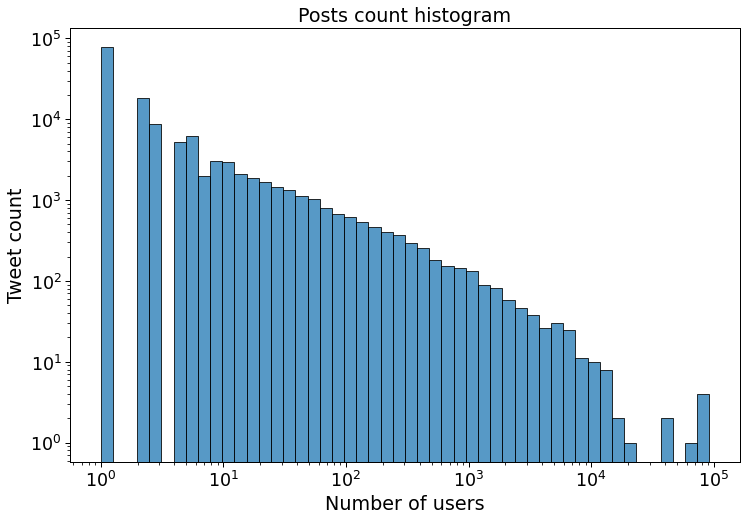

In [21]:
sns.set_context("paper", font_scale=2)

plt.figure(figsize=(12, 8))

sns.histplot(data=stats, x='tweet_count', bins=50, log_scale=True)
plt.yscale('log')
plt.title("Posts count histogram")
plt.xlabel("Number of users")
plt.ylabel("Tweet count")
None

### Average Sentiment and Stock Price

**First, let's use NLTK Sentiment Intensity Analyser to evaluate the sentiment for each tweet. Even though Sentiment Analyser does not compain when raw text is fed, lets help it a bit with a mild tweet text cleanup.**

In [22]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\ARINDAM
[nltk_data]     SARKAR\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
sentiment_nltk = SentimentIntensityAnalyzer()

# Mild cleaning: remove weblinks, $ticker_symbol, # symbol from hashtags, remove excessive spaces
tweet['prep_body'] = tweet['body'].replace(r"https?:\S+|http?:\S+|www?:\S+", '', regex=True).replace(r"[@#\$][a-zA-Z]+", '', regex=True).replace(r"\s\s+", ' ', regex=True).str.strip()

# The following 3 lines of code may take more than 30 minutes to execute
tweet['positive_sentiment'] = tweet['prep_body'].apply(lambda x: sentiment_nltk.polarity_scores(x)['pos'])
tweet['negative_sentiment'] = tweet['prep_body'].apply(lambda x: sentiment_nltk.polarity_scores(x)['neg'])
tweet['total_sentiment'] = tweet['prep_body'].apply(lambda x: sentiment_nltk.polarity_scores(x)['compound'])

tweet.head()

tweet_id           writer  \
0  550441509175443456  VisualStockRSRC   
1  550441672312512512      KeralaGuy77   
2  550441732014223360      DozenStocks   
3  550442977802207232     ShowDreamCar   
4  550443807834402816     i_Know_First   

                                                body  comment_num  \
0  lx21 made $10,008  on $AAPL -Check it out! htt...            0   
1  Insanity of today weirdo massive selling. $aap...            0   
2  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...            0   
3  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...            0   
4  Swing Trading: Up To 8.91% Return In 14 Days h...            0   

   retweet_num  like_num            datetime  \
0            0         1 2015-01-01 00:00:57   
1            0         0 2015-01-01 00:01:36   
2            0         0 2015-01-01 00:01:50   
3            0         1 2015-01-01 00:06:47   
4            0         1 2015-01-01 00:10:05   

                                           prep_body  positive_sentiment  \
0          lx21 made $10,008 on -Check it out! Learn                 0.0   
1  Insanity of today weirdo massive selling. bid ...                 0.0   
2                           S&P100 Performance more@                 0.0   
3  : Volkswagen Pushes 2014 Record Recall Tally H...                 0.0   
4       Swing Trading: Up To 8.91% Return In 14 Days                 0.0   

   negative_sentiment  total_sentiment  
0               0.000           0.0000  
1               0.352          -0.8271  
2               0.000           0.0000  
3               0.000           0.0000  
4               0.000           0.0000

In [29]:
#It is interesting to look again on duplicates in prepared tweets, after hashtags and weblinks were dropped.

print("Percent of cleaned duplicated tweets: {:.2f} %".format(sum(tweet['prep_body'].duplicated())/len(tweet) * 100))

Percent of cleaned duplicated tweets: 25.25 %


**After pre-processing the proportion of duplicated tweets increased from 10.35% to 25.25%. This indicates templates in about 15% of tweets, which could indicate bots.**

### Next, lets get the stock prices using Yahoo Finance API. For the sake of simplicity, consider only Closing price.

In [30]:
tweet['date'] = tweet['datetime'].dt.date

prices = yf.download(tickers=" ".join([st for st in company.keys() if st != "GOOGL"]),
    start=tweet['date'].min().strftime('%Y-%m-%d'),
    end=tweet['date'].max().strftime('%Y-%m-%d'),
    interval='1d'
).reset_index()

prices = prices.drop(["Adj Close", "Volume", "Open", "High", "Low"], axis=1)

prices.head()

[*********************100%***********************]  5 of 5 completed


Date      Close                                              
                   AAPL        AMZN        GOOG       MSFT       TSLA
0 2014-12-31  27.594999  310.350006  524.958740  46.450001  44.481998
1 2015-01-02  27.332500  308.519989  523.373108  46.759998  43.862000
2 2015-01-05  26.562500  302.190002  512.463013  46.330002  42.018002
3 2015-01-06  26.565001  295.290009  500.585632  45.650002  42.256001
4 2015-01-07  26.937500  298.420013  499.727997  46.230000  42.189999

In [31]:
#Aggregate sentiment from tweet by date and match with prices by date.

stats = tweet[['date', 'positive_sentiment', 'negative_sentiment', 'total_sentiment']].groupby('date').mean()

prices['date'] = prices['Date'].dt.date
prices = prices.drop(['Date'], axis=1)
stats = prices.join(stats, how='inner', on='date')

In [32]:
#Calculate sentiment-price correlation coefficient for closing prices

price_cols = [('Close', ticker) for ticker in company.keys() if ticker != 'GOOGL']
sentim_cols = ['positive_sentiment', 'negative_sentiment', 'total_sentiment']
stats[price_cols + sentim_cols].corr().loc[sentim_cols, price_cols].style.background_gradient(cmap='coolwarm')

**To further illustrate this correlation, below are the plots with normalized stock price and an overall positive sentiment as a function of date.**

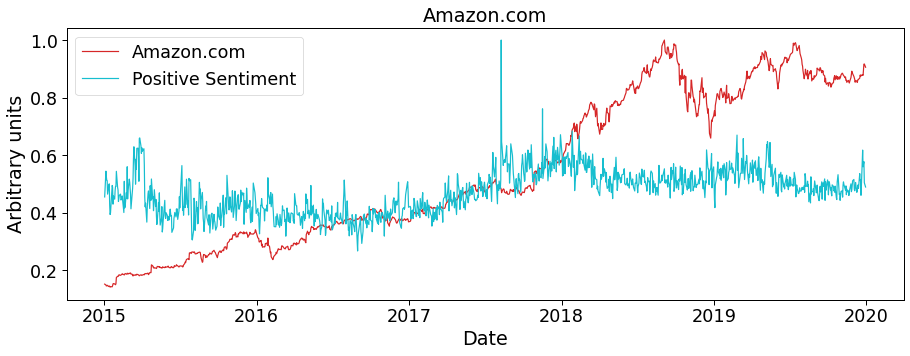

In [33]:
colors = {"AMZN" : "tab:red", 
          "GOOG" : "tab:blue", 
          "AAPL" : "tab:orange", 
          "MSFT" : "tab:purple", 
          "TSLA" : "tab:green"}

plt.figure(figsize=(15, 5))

t = "AMZN"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:cyan", label="Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

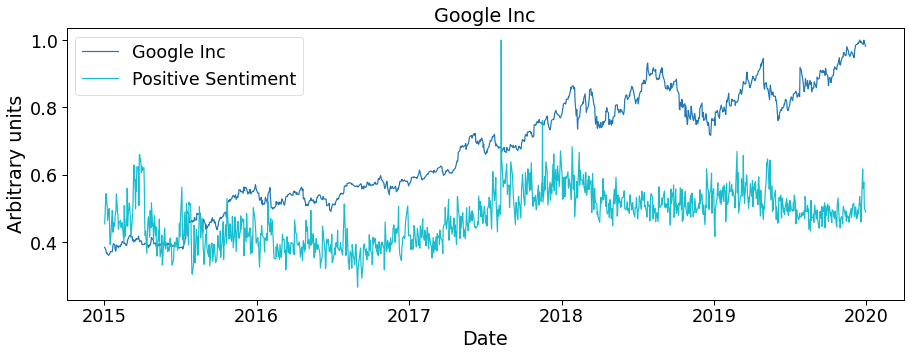

In [34]:
plt.figure(figsize=(15, 5))

t = "GOOG"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:cyan", label="Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

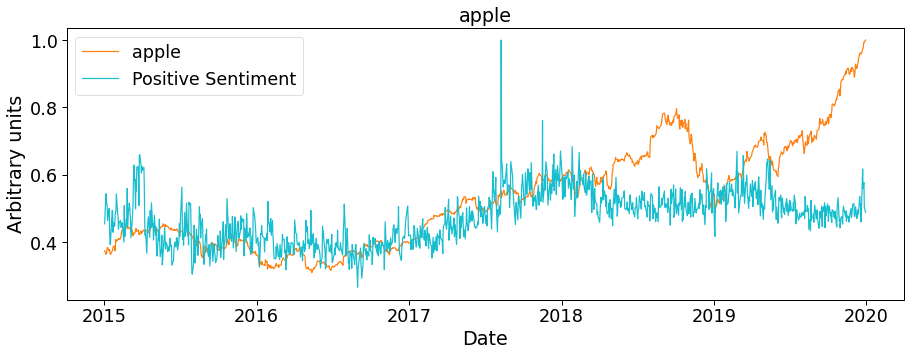

In [35]:
plt.figure(figsize=(15, 5))

t = "AAPL"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:cyan", label="Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

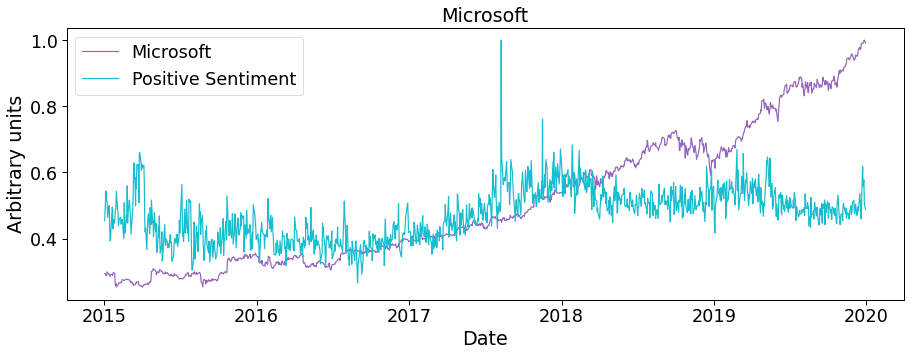

In [36]:
plt.figure(figsize=(15, 5))

t = "MSFT"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:cyan", label="Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

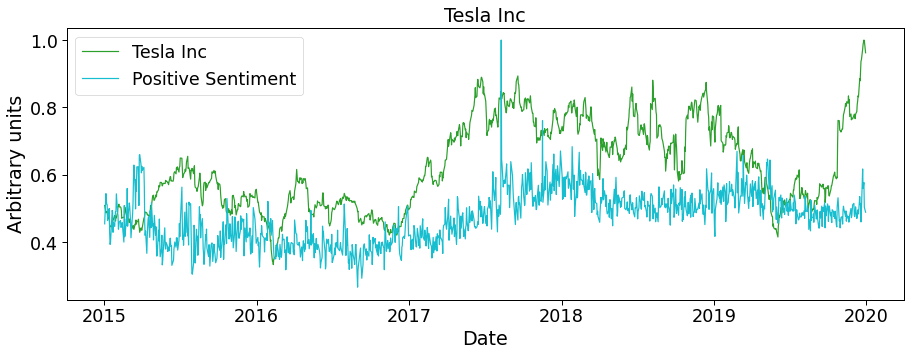

In [37]:
plt.figure(figsize=(15, 5))

t = "TSLA"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:cyan", label="Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

### Summary
**There seems to be a fair bit of correlation between stock prices and sentiment. In terms of total sentiment, which consists of both positive and negative tweets, the correlation is between 44 and 54%.**

**For all stocks considered, mean daily positive sentiment had a higher correlation to prices compared to total mean daily sentiment with ranges between 50 and 55%. In general, negative sentiment had less of a correlation to prices with a notable exception of Tesla, that had much less correlation.**

### Feature Engineering
**In case of twitter, an idea of influencing stock price via sentiment manipulation can be implemented via bot networks. Below I try to identify at least some of the accounts that could be bots.
To keep track of writers tweeting patters, lets introduce a "posters" table, which will be filled in as this exploration proceeds. The first feature that may tell something about the writer is what is their peak hourly tweet rate.**

In [38]:
tweet['hour'] = tweet['datetime'].dt.hour
data = tweet[['writer', 'hour', 'date', 'tweet_id']].groupby(['writer', 'hour', 'date']).count().reset_index().rename(columns={'tweet_id' : 'tweet_rate'})

tweet = tweet.drop(['hour'], axis=1)

indmax = data.groupby('writer').agg({'tweet_rate' : 'idxmax'})
posters = data.iloc[indmax.tweet_rate].sort_values(by='tweet_rate').set_index('writer')
posters = posters.drop(['hour', 'date'], axis=1).rename(columns={'tweet_rate' : 'max_tweet_rate'})
posters

max_tweet_rate
writer                        
0000derek                    1
dumbuz2889                   1
dumbmoney77                  1
dumbfortheday                1
dumbertrader                 1
...                        ...
It_c0nsulting               93
computer_hware              96
_peripherals                98
Stock2Bounce               134
MarketParse                259

[140131 rows x 1 columns]

In [39]:
#Next, lets get a mean tweet rate by each poster during each hour, from 0am to 23pm.

hours = data[['writer', 'hour', 'tweet_rate']].groupby(['writer', 'hour']).mean().sort_values(by='tweet_rate')
hours = hours.reset_index().pivot(index='writer', columns='hour', values='tweet_rate').fillna(0)
hours.columns.name = None
posters = posters.join(hours, how='outer')
posters.sort_values(by='max_tweet_rate').head()

max_tweet_rate    0    1    2    3    4    5    6    7    8  \
writer                                                                       
0000derek                   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
dumbuz2889                  1  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
dumbmoney77                 1  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
dumbfortheday               1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0   
dumbertrader                1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 9   10   11   12   13   14   15   16   17   18   19   20  \
writer                                                                      
0000derek      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   
dumbuz2889     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
dumbmoney77    0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0   
dumbfortheday  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
dumbertrader   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

                21   22   23  
writer                        
0000derek      0.0  0.0  0.0  
dumbuz2889     0.0  0.0  0.0  
dumbmoney77    1.0  1.0  0.0  
dumbfortheday  0.0  1.0  0.0  
dumbertrader   0.0  0.0  0.0

### Plot sample writers average hourly tweet rate (while active)

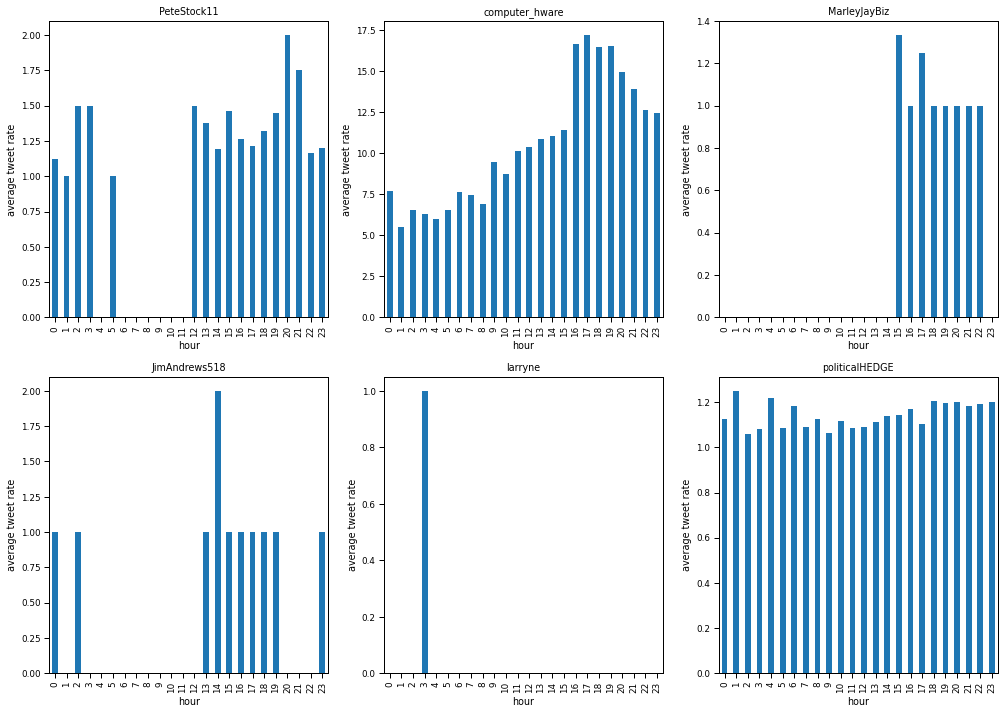

In [40]:
sns.set_context("paper", font_scale=1)

columns = list(range(24))

nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(17, 12))

sample_writers = ['PeteStock11', 'JimAndrews518', 'computer_hware', 'larryne', 'MarleyJayBiz', 'politicalHEDGE']

for i, writer in enumerate(sample_writers):
    c = i // 2
    r = i - nrows * c
    
    posters.loc[writer, columns].plot(kind='bar', ax=axs[r, c])
    axs[r, c].set_title(writer)
    axs[r, c].set_ylabel("average tweet rate")
    axs[r, c].set_xlabel("hour")
    
plt.show()
None

### Average time between subsequent tweets
**Too short time between succesive tweets can indicate a machine authorship. To account for long abscence, such as vocations, limit to shortest 75% of time intervals (in seconds). For writers with only one tweet, assign the maximum value to the time between tweets "mean_diff_sec".**

In [41]:
def in_qrange(ser, q):
    return ser.between(*ser.quantile(q=q))

tweet['timediff'] = tweet.sort_values('datetime', ascending=False).groupby(['writer']).datetime.diff(-1).dt.seconds.fillna(np.inf)

In [42]:
data = tweet.loc[tweet['timediff'].transform(in_qrange, q=[0, 0.75]), ['writer', 'timediff']].groupby('writer').agg(['mean']).rename(columns={'mean' : 'mean_diff_sec'})
data.columns = data.columns.droplevel()

tweet = tweet.drop(['timediff'], axis=1)

posters = posters.join(data, on='writer', how='left').fillna(max(data['mean_diff_sec']))
posters.loc[posters['mean_diff_sec'] == 0, 'mean_diff_sec'] = max(data['mean_diff_sec'])
posters.sort_values(by='mean_diff_sec').head()

max_tweet_rate    0    1    2    3    4    5    6    7    8  \
writer                                                                        
thelonelyghost               4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
SobchakCapital               4  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ewesoff                      4  1.0  0.0  0.0  0.0  4.0  1.0  0.0  0.0  0.0   
e_regeneration               7  7.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
benjmnr                      4  0.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0   

                  9   10   11   12   13   14   15   16   17   18   19   20  \
writer                                                                       
thelonelyghost  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.0   
SobchakCapital  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
ewesoff         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
e_regeneration  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
benjmnr         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   

                 21   22   23  mean_diff_sec  
writer                                        
thelonelyghost  0.0  0.0  0.0       0.333333  
SobchakCapital  0.0  0.0  0.0       0.333333  
ewesoff         0.0  0.0  0.0       0.333333  
e_regeneration  1.0  0.0  0.0       0.333333  
benjmnr         0.0  0.0  0.0       0.333333

In [43]:
# Fraction of non-original tweets
data = tweet.loc[tweet['prep_body'].duplicated(), ['writer', 'tweet_id']].groupby('writer').count().rename(columns={'tweet_id' : 'duplicate_posts'})

posters = posters.join(tweet[['writer', 'tweet_id']].groupby('writer').count().rename(columns={'tweet_id' : 'total_posts'}), how='left')

In [44]:
posters = posters.join(data, how='left').fillna(0)
posters['duplicate_posts'] = posters['duplicate_posts']/posters['total_posts']
posters.head()

max_tweet_rate    0    1    2    3    4    5    6    7    8    9  \
writer                                                                          
0000derek                 1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
00012859dn                1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
0001_Trader               3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
000Cloxd000               1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
000or00                   1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

              10   11   12   13   14   15   16   17   18   19   20   21   22  \
writer                                                                         
0000derek    0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0   
00012859dn   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
0001_Trader  0.0  0.0  1.0  1.0  1.0  2.0  3.0  0.0  1.0  0.0  0.0  0.0  1.0   
000Cloxd000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
000or00      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

              23  mean_diff_sec  total_posts  duplicate_posts  
writer                                                         
0000derek    0.0    7473.500000            9         0.222222  
00012859dn   0.0   37546.000000            1         0.000000  
0001_Trader  0.0   12409.333333           18         0.000000  
000Cloxd000  0.0   37546.000000            1         1.000000  
000or00      0.0   37546.000000            1         1.000000

### Some of the conclusion whenever a poster is a bot or not can be drawn based on the collected features. For example:

**abnormal hourly tweet rate ("max_tweet_rate")
too short mean time between successive tweets ("mean_diff_sec")
lack of hours with no tweets (too few hour columns, "0" to "23", when tweet rate was 0)
all tweets are among the duplicates ("duplicate_posts" = 1.0)
With a crude criteria, such as abnormal endurance ("max_tweet_rate" of 100 or more) or extreme typing speed ("mean_diff_sec" of 5 or less) or no sleep abilty (no hour columns with tweet rate of 3), some bots can be found.**

In [45]:
columns = list(range(24))
bot_check = pd.DataFrame(index=posters.index)

bot_check["max_tweet_rate"] = (posters["max_tweet_rate"] > 100).astype(np.int8)
bot_check["mean_diff_sec"] = (posters["mean_diff_sec"] < 10).astype(np.int8)
bot_check["abscence_hours"] = ((posters[columns] == 0).astype(int).sum(axis=1) < 3).astype(np.int8)
bot_check["all_duplicates"] = (posters["duplicate_posts"] == 1).astype(np.int8)

bot_check.head()

max_tweet_rate  mean_diff_sec  abscence_hours  all_duplicates
writer                                                                    
0000derek                 0              0               0               0
00012859dn                0              0               0               0
0001_Trader               0              0               0               0
000Cloxd000               0              0               0               1
000or00                   0              0               0               1

In [46]:
print("max hourly tweet rate > 100 : {} writers".format(sum(bot_check["max_tweet_rate"])))

max hourly tweet rate > 100 : 2 writers


In [47]:
print("mean time between tweets sec < 5 seconds : {} writers".format(sum(bot_check["mean_diff_sec"])))

mean time between tweets sec < 5 seconds : 143 writers


In [48]:
print("less than 3 hours of not tweeting : {} writers".format(sum(bot_check["abscence_hours"])))

less than 3 hours of not tweeting : 1314 writers


In [49]:
print("not a single original post : {} writers".format(sum(bot_check["all_duplicates"])))

not a single original post : 41957 writers


### "If it tweets like a bot, it is a bot"
**Bootstraping: find all tweets from writers with at least a two flag in "bot_check". All other writers from "bot_check" that tweeted one of such tweets get a flag for "tweet_like_a_bot". Re-count writres with at least two flags.**

In [50]:
bot_check[bot_check.sum(axis=1) > 1]

max_tweet_rate  mean_diff_sec  abscence_hours  all_duplicates
writer                                                                        
CBuck81TV                     0              1               0               1
Chardenee18                   0              1               0               1
EngkisK                       0              1               0               1
FAJSYSTEMS                    0              1               0               1
IncomeREIT                    0              1               0               1
Javan_Andrew                  0              1               0               1
JoshuaCEwell                  0              1               0               1
KingRichard128                0              1               0               1
MarketParse                   1              0               1               0
RealTraderGeek                0              1               0               1
RobinhoodPromo                0              0               1               1
Samantha_Lamb_                0              1               0               1
StockSaintsPrem               0              1               0               1
StrategyAcad                  0              1               0               1
bcarpano                      0              1               0               1
byCyril                       0              1               0               1
impeachTHEpotus               0              1               0               1
mehranhydary                  0              1               0               1
myforexchart                  0              1               0               1
rival96618425                 0              1               0               1
snowbirdie_xo                 0              1               0               1
tweetchristo                  0              1               0               1
uchinatravel                  0              1               0               1
williaj51                     0              1               0               1
yinyang211985                 0              1               0               1

In [51]:
#On the first count, there are only 25 writers with two ore more flags.

bot_tweets = tweet.loc[tweet['writer'].isin(bot_check[bot_check.sum(axis=1) > 1].index), 'prep_body'].unique()
bot_check['tweet_like_bot'] = bot_check.index.isin(tweet.loc[tweet['prep_body'].isin(bot_tweets), 'writer'].unique()).astype(np.int8)

In [52]:
print("Percent of bots : {:.2f}%".format(sum(bot_check.sum(axis=1) > 1)/len(posters)*100))

Percent of bots : 21.41%


In [53]:
bots = bot_check.loc[bot_check.sum(axis=1) > 1].index
tweet['group'] = 'user'
tweet.loc[tweet.writer.isin(bots), 'group'] = 'bot'

## Summary
**There seems to be 21.41%, or 29996 bots of 140131 uniqie writers in the dataset. This number was obtained via a two stage process. Firstly, four features were calculated for each writer:**

**abnormal hourly tweet rate ("max_tweet_rate")
too short mean time between successive tweets ("mean_diff_sec")
lack of hours with no tweets (too few hour columns, "0" to "23", when tweet rate was 0)
all tweets are among the duplicates ("duplicate_posts" = 1.0)
Next, writers with at least two flags were deemed to be bots. At this stage there were only 25 such writers. Next, all their tweets were found and stored in the table "bot_tweets". Then, an additional feature, that determines whenever a writer posted one of the tweets from "bot_tweets". Finally, with five features writers were tallied again and those with at least two flags were deemed to be bots.**

### How does Bot sentiment correlates with Stock Price?

In [54]:
stats = tweet[tweet['group']=="bot"][['date', 'positive_sentiment', 'negative_sentiment', 'total_sentiment']].groupby('date').mean()

stats = prices.join(stats, how='inner', on='date')

In [55]:
price_cols = [('Close', ticker) for ticker in company.keys() if ticker != 'GOOGL']
sentim_cols = ['positive_sentiment', 'negative_sentiment', 'total_sentiment']
stats[price_cols + sentim_cols].corr().loc[sentim_cols, price_cols].style.background_gradient(cmap='coolwarm')

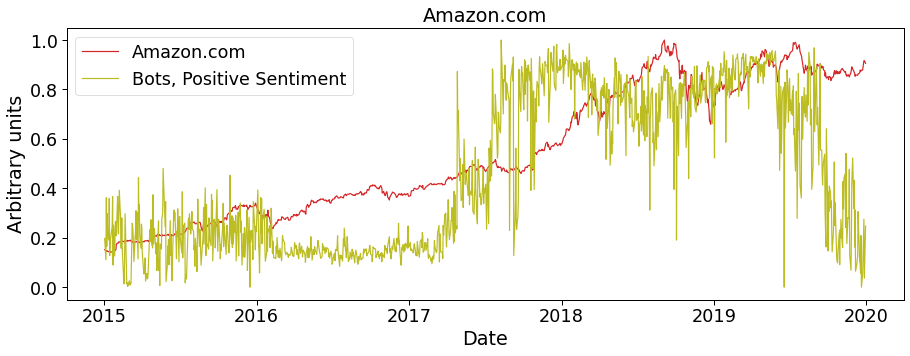

In [56]:
sns.set_context("paper", font_scale=2)

plt.figure(figsize=(15, 5))

t = "AMZN"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:olive", label="Bots, Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

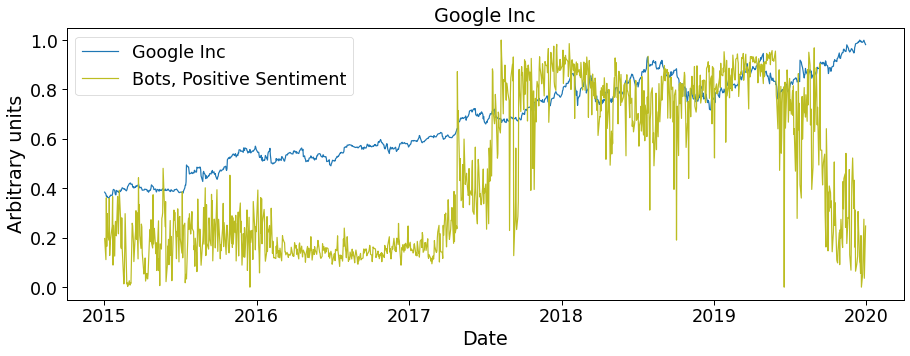

In [57]:
plt.figure(figsize=(15, 5))

t = "GOOG"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:olive", label="Bots, Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

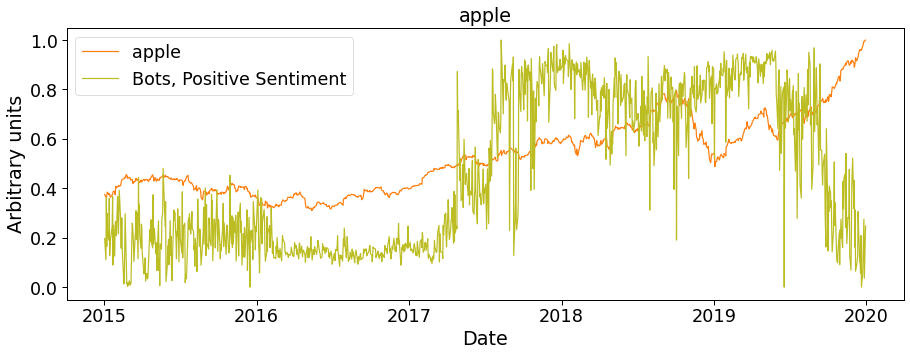

In [58]:
plt.figure(figsize=(15, 5))

t = "AAPL"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:olive", label="Bots, Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

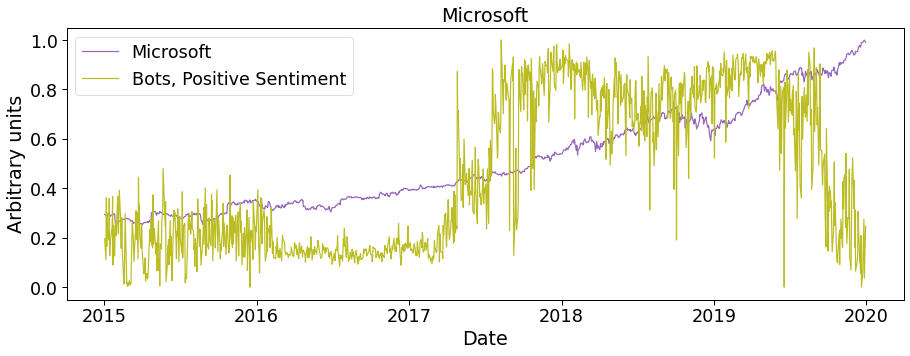

In [59]:
plt.figure(figsize=(15, 5))

t = "MSFT"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:olive", label="Bots, Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

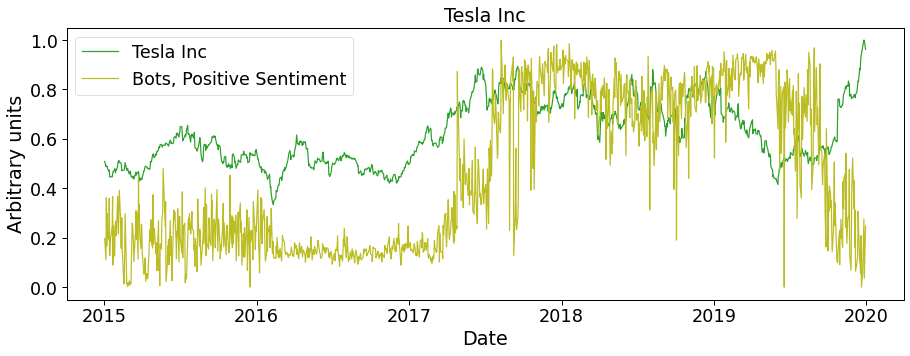

In [60]:
plt.figure(figsize=(15, 5))

t = "TSLA"

sns.lineplot(x=stats["date"], y=stats[("Close", t)]/max(stats[("Close", t)]), color=colors[t], label=company[t])
sns.lineplot(x=stats["date"], y=stats["positive_sentiment"]/max(stats["positive_sentiment"]), color="tab:olive", label="Bots, Positive Sentiment")
plt.title(company[t])
plt.xlabel("Date")
plt.ylabel("Arbitrary units")
None

### Summary
**Bots combined seem to be astonishingly more impactful than average for Google, Microsoft and Amazon in terms of positive sentiment and total sentiment. For these companies total sentiment by bot tweets seems to be up to 20-25% more impactful than average. For Apple total bot sentiment exhibits 10% increase compared to average, still a formidable effect. The correlation is significantly reduced for Tesla, where it differs from the average by only 1%.**

**Interestingly, there is a significant difference between negative sentiment from bot tweets compared to overall negative sentiment in terms of correlation to stock prices. Average negative sentiment was positively correlated with stock prices, while negative bot sentiment was negatively correlated to stock prices.**